# PDE approach and lower/upper bounds

In [177]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

## PDE

As usual when it comes to price an option based on PDE's model, we define:
$$\phi(t,x)= \mathbb E \left[ \left[ \int_{t}^{T} \frac{S_{t}}{T}\,dt-x \right]_{+} \ \Big\vert \ S_{t}=1 \right]$$

Let $f$ be the discounted value of $\phi$ which satisfies (as shown theoritically) $\dot f=-Gf$ with $G$ the following operator:
$$G \equiv \frac{1}{2} \sigma^2 x^2 \frac{\partial^2}{\partial x^2} - (\rho_t + r*x) \frac{\partial}{\partial x}$$

The following part aims to solve the corresponding PDE, with initial condition: $f(T,.)=x^-$.




In [178]:
#Definition of parameters
K,r,S0,T,sigma=100,0.03,100,1,0.2

# Additional parameters

rho_t = 1/T #we choose here a uniform distribution


# Discretization of space and time
T = 1.0  # Time
L = 10  # Space length
Nx = 501 # Space discretization
Nt = 1501 # Time discretization
dx = L/Nx
dt = T/Nt

# Initial conditions
initial_x_values = np.linspace(-L/2, L/2, Nx)
x_values = np.linspace(-L/2, L/2, Nx)
f_values =np.maximum(-x_values, 0.0)

# Discretization of operator G
def G_operator(x, f):
    dfdx=np.gradient(f, x)
    second_derivative_term = 0.5*((sigma**2)* x**2) * np.gradient(dfdx, x)
    first_derivative_term = -((rho_t + r * x) * np.gradient(f, x))

    G_matrix = second_derivative_term + first_derivative_term
    return G_matrix


start = perf_counter()
# Time evolution by finite differences
for n in range(Nt-1):
    G_matrix = G_operator(x_values,f_values)
    f_values = f_values + dt * G_matrix
end = perf_counter()
print(f'{(end  - start):.3f}')

0.500


In [179]:
# Value for sigma=25%, K=S0=100, T=1 and r=3%
print(x_values[300])
print(S0*f_values[300])

1.0
5.047553051714263


The price of the Asian option is then given by $ S_0 f(0, K S_0^{-1})$.

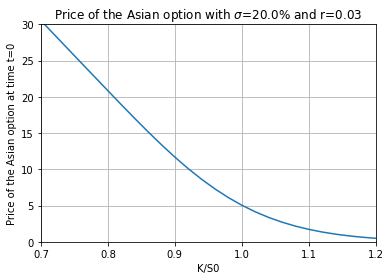

In [180]:
plt.plot(x_values,S0*f_values)
plt.grid(True)
plt.xlabel('K/S0')
plt.ylabel('Price of the Asian option at time t=0')
Sigma=r"$\sigma$"
plt.xlim(0.7,1.2)
plt.ylim(0,30)
plt.ion()
plt.title("Price of the Asian option with {}={}% and r={}".format(Sigma, 100*sigma,r))
plt.show()

### Convergence inequalities

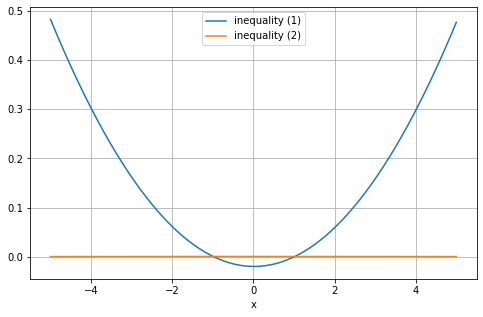

In [181]:
#Verify conditions of convergences:

fig, ax = plt.subplots(figsize=(8, 5))

Condition1 = lambda x: -abs(1+r*x)*dx+0.5*(sigma*x)**2
Condition2= lambda x: dx**2 -0.5*dt*(sigma*x)**2
difference1= [Condition1(x) for x in x_values]
difference2= [Condition2(x) for x in x_values]
ax.plot(x_values,difference1,label='inequality (1)')
ax.plot(x_values,difference2,label='inequality (2)')
# ax.set_title("Inequalities ensuring convergence of the scheme {}={}% and r={}\n".format(Sigma, 100*sigma,r))
ax.set_xlabel('x')

ax.grid()
ax.legend();

In [182]:
# fig.savefig(fname='../rapport/charts/Ineq.png', dpi=300);

## Bounds

### Lower bound

In [183]:
import scipy.integrate as integrate

#Defining the integrand of the integral defining E(Y|Z)

v=1/3
def E_Y_Z(x,sigma,v,r):
  m = lambda t: 3*t*(2-t)/2
  integral = integrate.quad(lambda t: np.exp(sigma*m(t)*x - 0.5*v*(m(t)**2)*(sigma**2) + r*t),0,1)
  return integral[0]

def lower_bound(sigma,v,r,S0,K):
  density= lambda x: np.exp(-3*(x**2)/2)/np.sqrt(2*np.pi/3)

  return np.exp(-r)*integrate.quad(lambda x: density(x)*np.maximum(0,S0*E_Y_Z(x,sigma,v,r)-K),-np.inf,np.inf)[0]

lower_bound(sigma,v,r,S0,100)

5.282973131573647

### Upper bound

In [184]:
gamma1=9
gamma2=r+0.25*sigma**2
c=1/3

A1 = c*np.exp(gamma2 + c*sigma**2)*(sigma**2)
A2 = 0.5*(sigma**2)*gamma1*v*np.exp(0.5*gamma1*v*(sigma**2)) + 0.5*(gamma2**2)
B = 0.5*(sigma**4)*(c**2)*np.exp((sigma**4)*(c**2))*(1+gamma2)
Maj=np.exp(-r)*0.5*np.sqrt(A1*A2 + B)

upper_bound=lower_bound(sigma,v,r,S0,100)+Maj
print(upper_bound)

5.298315044054196


In [185]:
Maj

0.015341912480549492

### Results

In [186]:
start = perf_counter()

A1 = c*np.exp(gamma2 + c*sigma**2)*(sigma**2)
A2 = 0.5*(sigma**2)*gamma1*v*np.exp(0.5*gamma1*v*(sigma**2)) + 0.5*(gamma2**2)
B = 0.5*(sigma**4)*(c**2)*np.exp((sigma**4)*(c**2))*(1+gamma2)
Maj=np.exp(-r)*0.5*np.sqrt(A1*A2 + B)

lb = lower_bound(sigma,v,r,S0,S0)
ub = lb + Maj

res = (lb + ub)/2
ci = (ub - lb)/2

end = perf_counter()

print(end - start)
print(res)
print(ci)

0.11476664099973277
5.290644087813922
0.0076709562402745846


### Charts

In [187]:
f_lower_bounds=np.array([lower_bound(sigma,v,r,S0,S0*x) for x in x_values])
f_upper_bounds=f_lower_bounds+Maj

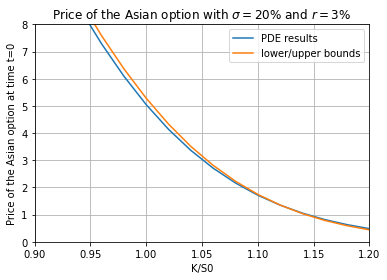

In [188]:
#Plot the results:

fig, ax = plt.subplots()
ax.plot(x_values,S0*f_values,label='PDE results')
ax.plot(x_values,f_lower_bounds,label='lower/upper bounds')
# ax.plot(x_values,f_upper_bounds, label='upper bounds')
ax.grid(True)
ax.set_xlabel('K/S0')
ax.set_xlim(0.9,1.2)
ax.set_ylim(0,8)
ax.set_ylabel('Price of the Asian option at time t=0')
ax.legend()
ax.set_title(f"Price of the Asian option with $\sigma={100*sigma:.0f}$% and $r={100*r:.0f}$%");

In [189]:
# fig.savefig(fname='../rapport/charts/Price_bounds15.png', dpi=300);

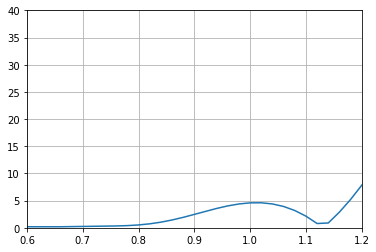

In [190]:
relative_error=[100*np.mean([abs(S0*f_values[i]-f_lower_bounds[i]),abs(S0*f_values[i]-f_upper_bounds[i])])/(f_upper_bounds[i]) for i in range(len(f_values))]
plt.plot(x_values,relative_error)
plt.xlim(0.6,1.2)
plt.ylim(0,40)
plt.grid()
plt.show()